In [50]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
# from models.non_constant_diffusivity import NonConstantDiffusivityNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from trainers.train import train_loop

In [51]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/non_linear/non_linear_decomposition.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/non_linear')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/non_linear/model_POD')


# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear/model_POD


In [52]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear/non_linear_decomposition.pkl


In [53]:
DEVICE = 'cpu'

In [54]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [55]:
X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

In [56]:
import torch
import torch.nn as nn

from vecopsciml.utils import TensOps
from vecopsciml.operators.zero_order import Mx, My

class POD_PGNNIV(nn.Module):
    def __init__(self, input_size, POD_output, explanatory_output_size, POD_base, device, **kwargs):
        super(POD_PGNNIV, self).__init__()

        self.input = input_size
        self.POD_output = POD_output
        self.output_expl = explanatory_output_size

        self.hidden_units_pred = 10
        self.hidden_units_exp = 15
        self.filters_exp = 10

        self.base = POD_base.to(device)

        self.device = device

        # # Predictive network
        self.flatten_layer_pred = nn.Flatten(start_dim=1, end_dim=-1)
        self.hidden1_layer_pred = nn.Linear(torch.prod(torch.tensor(self.input, device=self.device)), self.hidden_units_pred).to(self.device)
        self.hidden2_layer_pred = nn.Linear(self.hidden_units_pred, self.hidden_units_pred).to(self.device)
        self.output_layer_pred = nn.Linear(self.hidden_units_pred, self.POD_output).to(self.device)

        # Explanatory network (commented out since they are not used in forward method)
        self.conv1_exp = nn.Conv2d(in_channels=1, out_channels=self.filters_exp, kernel_size=1).to(self.device)
        self.flatten_layer_exp = nn.Flatten().to(self.device)
        self.hidden1_layer_exp = nn.LazyLinear(self.hidden_units_exp).to(self.device)
        self.hidden2_layer_exp = nn.Linear(self.hidden_units_exp, self.hidden_units_exp).to(self.device)
        self.output_layer_exp = nn.Linear(self.hidden_units_exp, self.filters_exp * (self.output_expl[1] - 1) * (self.output_expl[2] - 1)).to(self.device)
        self.conv2_exp = nn.Conv2d(in_channels=self.filters_exp, out_channels=1, kernel_size=1).to(self.device)

    def forward(self, X):

        X = X.to(self.device)

        # Predictive network
        X = self.flatten_layer_pred(X)
        X = torch.sigmoid(self.hidden1_layer_pred(X))
        X = torch.sigmoid(self.hidden2_layer_pred(X))
        output_predictive_net = self.output_layer_pred(X)

        u_pred = torch.mm(self.base, output_predictive_net.T).T.reshape(output_predictive_net.shape[0], self.output_expl[0], self.output_expl[1], self.output_expl[2])
        um_pred = My(Mx(TensOps(u_pred, space_dimension=2, contravariance=0, covariance=0))).values

        x = torch.sigmoid(self.conv1_exp(um_pred))
        x = self.flatten_layer_exp(x)
        x = torch.sigmoid(self.hidden1_layer_exp(x))
        x = torch.sigmoid(self.hidden2_layer_exp(x))
        x = self.output_layer_exp(x)
        x = x.view(x.size(0), self.filters_exp, self.output_expl[1] - 1, self.output_expl[2] - 1)
        K_pred = self.conv2_exp(x)

        return u_pred, K_pred

In [57]:
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1).to(DEVICE)
y_train = TensOps(torch.Tensor(dataset['y_train']).unsqueeze(1).requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
K_train = TensOps(torch.tensor(dataset['k_train']).unsqueeze(1).to(torch.float32).requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
f_train = TensOps(torch.tensor(dataset['f_train']).unsqueeze(1).to(torch.float32).requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

X_val = torch.Tensor(dataset['X_val']).unsqueeze(1).to(DEVICE)
y_val = TensOps(torch.Tensor(dataset['y_val']).unsqueeze(1).requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val']).unsqueeze(1).to(torch.float32).requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val']).to(torch.float32).unsqueeze(1).requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

print("Train dataset length:", len(X_train))
print("Validation dataset length:", len(X_val))

Train dataset length: 8000
Validation dataset length: 2000


In [58]:
num_modes = 14

input_shape = X_train[0].shape
POD_shape = num_modes
output_shape = y_train.values[0].shape

In [59]:
U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1).T, full_matrices=False)

num_modes = 14

U_reduced_train = U_train[:, :num_modes]
S_reduced_train = S_train[:num_modes]
Vt_reduced_train = Vt_train[:num_modes, :]

modes_base_train = torch.mm(U_reduced_train, torch.diag(S_reduced_train))

In [60]:
POD_model = POD_PGNNIV(input_size=input_shape, POD_output=POD_shape, explanatory_output_size=output_shape, POD_base=modes_base_train, device=DEVICE)
optimizer = torch.optim.Adam(POD_model.parameters(), lr=1e-4)

model, optimizer, lists = load_results(POD_model, optimizer, MODEL_RESULTS_PATH, map_location=torch.device('cpu'))

In [61]:
def smooth_curve(data, window_size=200):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    # Imprimir los resultados
    print(f"Mínimo: {minimo:.2e}")
    print(f"Máximo: {maximo:.2e}")
    print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
    print(f"Mediana (Q2): {mediana:.2e}")
    print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")


def relative_error_return_Q(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))
    
    tercer_cuartil = np.percentile(prediction_error, 75)

    Q_bool = prediction_error <= tercer_cuartil

    return Q_bool

def relative_error(validation, prediction, dx=dx, dy=dy):
    return np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

def calculate_error(validation_data, predicted_data):
    numerator = np.trapz(np.trapz((validation_data - predicted_data)**2))
    denominator = np.trapz(np.trapz((validation_data)**2))

    if np.all(denominator == 0):
        result = np.sqrt(numerator)
    else:
        result = np.sqrt(numerator / denominator)
    return result

In [62]:
linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(16)
height = cm_to_in(8) 

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [63]:
y_pred, K_pred = model(X_val)

y_pred = TensOps(y_pred, space_dimension=2, contravariance=0, covariance=0)
K_pred = TensOps(K_pred, space_dimension=2, contravariance=0, covariance=0)

u_validation = y_val.values.detach()
u_prediction = y_pred.values.detach()

um_validation = zo.Mx(zo.My(y_val)).values.detach()
um_prediction = zo.Mx(zo.My(y_pred)).values.detach()

K_validation = zo.My(zo.Mx(K_val)).values.detach()
K_prediction = K_pred.values.detach()

qx_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qx_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qx_prediction = azo.scalar_product(K_pred, zo.Dx(y_pred, D)).values.detach()

qy_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qy_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qy_prediction = azo.scalar_product(K_pred, zo.Dy(y_pred, D)).values.detach()

In [64]:
def plot_boxplot_and_colormaps(validation_solution, predicted_solution, variable, problem):

    validation_solution = validation_solution[:, 0]
    predicted_solution = predicted_solution[:, 0]

    colors = sns.color_palette("hls", 8)
    
    solution_error = relative_error(validation=validation_solution, prediction=predicted_solution).squeeze()

    min = np.percentile(solution_error, 5)
    max = np.percentile(solution_error, 95)  
    min_index = np.argmin(np.abs(solution_error - min))
    max_index = np.argmin(np.abs(solution_error - max))

    # --------------------------------------------------------------------------------------

    plt.figure(figsize=(width/1.5, 2*height))

    sns.boxplot(y=solution_error, color=colors[4], width=0.4)  
    sns.stripplot(y=solution_error, color=colors[5], jitter=0.1, size=3, alpha=0.4, edgecolor='black', linewidth=0.11)
    plt.scatter(x=0, y=solution_error[min_index], color=colors[0], edgecolor='black', label='P5', zorder=4)
    plt.scatter(x=0, y=solution_error[max_index], color=colors[1], edgecolor='black', label='P95', zorder=4)

    plt.xlim(-0.5, 0.5)
    plt.ylabel('$E_r$', fontsize=label_fontsize)
    plt.yscale('log')
    plt.legend(loc='upper left', fontsize=legend_fontsize)
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_{problem}_boxplot.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

    # --------------------------------------------------------------------------------------

    combined_data = np.concatenate((validation_solution[min_index].numpy().flatten(), predicted_solution[min_index].numpy().flatten()))
    vmin = np.min(combined_data)
    vmax = np.max(combined_data)

    fig, axs = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'wspace': 0.4})
    plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom)  

    im1 = axs[0].imshow(validation_solution[min_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    im2 = axs[1].imshow(predicted_solution[min_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.set_xticks(np.arange(0, 1.1, 0.2))
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_{problem}_min.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

    # --------------------------------------------------------------------------------------

    combined_data = np.concatenate((validation_solution[max_index].numpy().flatten(), predicted_solution[max_index].numpy().flatten()))
    vmin = np.min(combined_data)
    vmax = np.max(combined_data)

    fig, axs = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'wspace': 0.4})
    plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom)  

    im1 = axs[0].imshow(validation_solution[max_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    im2 = axs[1].imshow(predicted_solution[max_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.set_xticks(np.arange(0, 1.1, 0.2))
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_{problem}_max.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

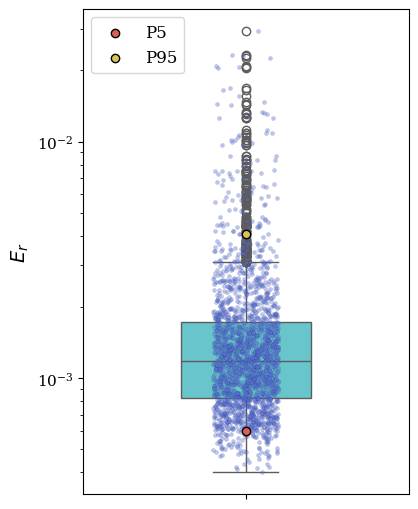

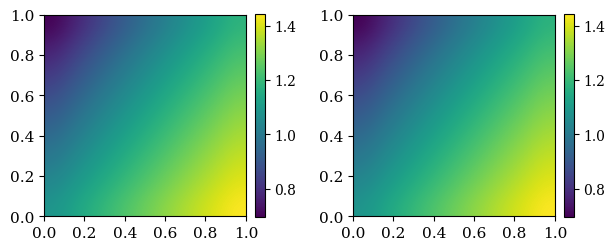

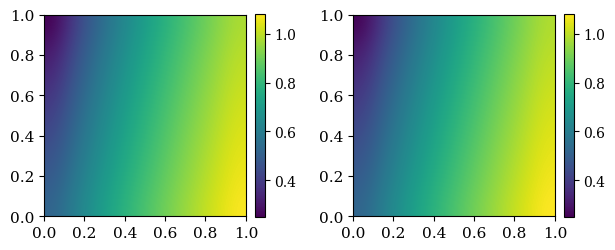

In [65]:
plot_boxplot_and_colormaps(validation_solution=u_validation, predicted_solution=u_prediction, variable='solution', problem='nonlinear_P4')

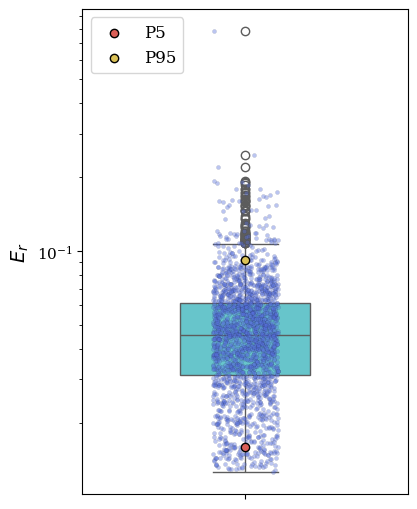

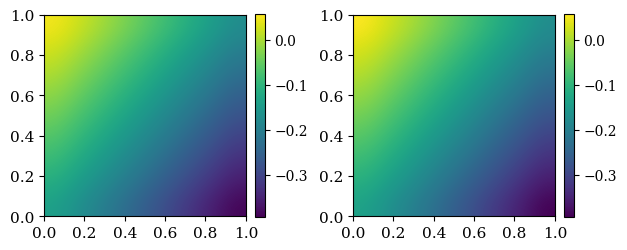

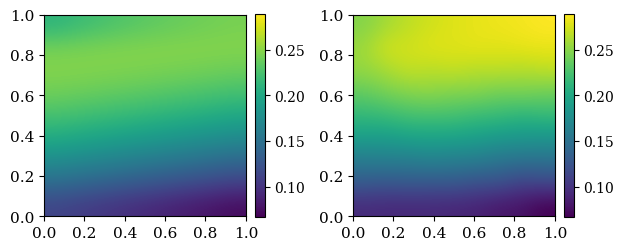

In [66]:
plot_boxplot_and_colormaps(validation_solution=K_validation, predicted_solution=K_prediction, variable='K', problem='nonlinear_P4')

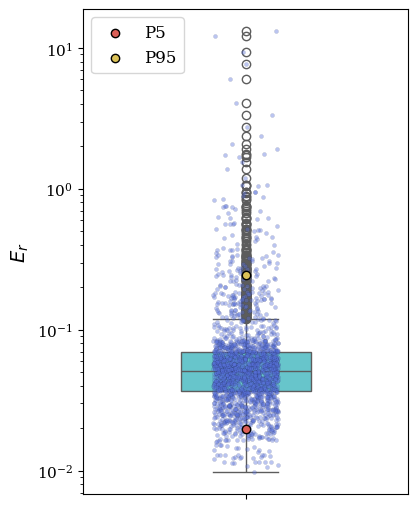

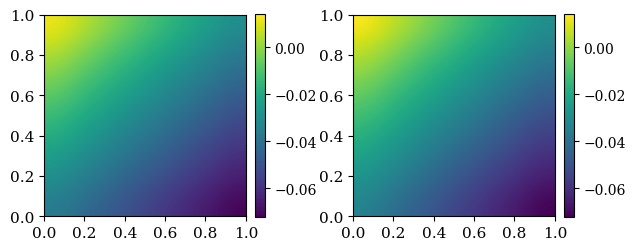

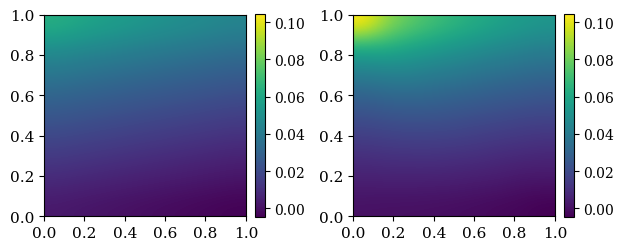

In [67]:
plot_boxplot_and_colormaps(validation_solution=qx_validation, predicted_solution=qx_prediction, variable='qx', problem='nonlinear_P4')

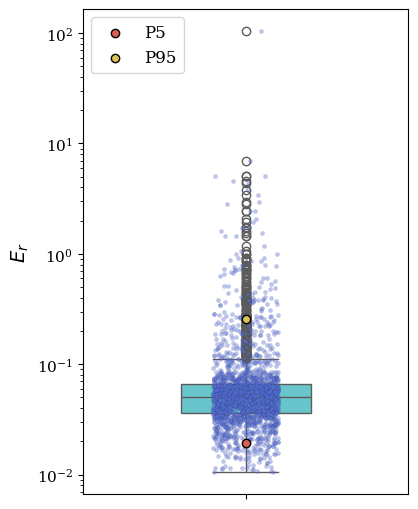

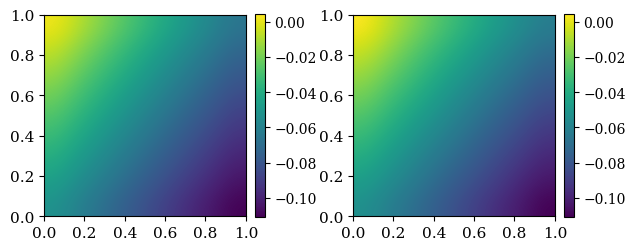

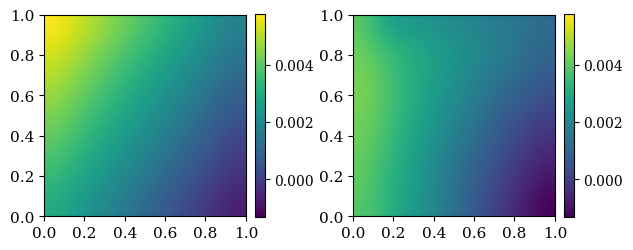

In [68]:
plot_boxplot_and_colormaps(validation_solution=qy_validation, predicted_solution=qy_prediction, variable='qy', problem='nonlinear_P4')